<a href="https://colab.research.google.com/github/am610/GW_ML/blob/main/NN_GW_highres_RF_FREQUENCY_s15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### @Ayan Mitra
##### 2022

In [2]:
#@title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import joblib
import io
# Load Statsmodels 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import logging
logging.getLogger('tensorflow').disabled = True
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA, IncrementalPCA
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm,Normalize
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import scipy.fftpack
#import hampel
import random
import sklearn
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# evaluate multinomial logistic regression model
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import warnings
warnings.filterwarnings('ignore')
import sys
import seaborn as sns
from pylab import *
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as mpl
from scipy import interpolate
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.decomposition import PCA
from google.colab import files
from scipy.fft import fft, ifft, fftfreq

column = ['t','orig_w','filt_w','smt_w']

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def plot(i):
  plt.plot(Time.iloc[i],Signal.iloc[i],'.',label='%s'%i)
  plt.legend()
  plt.show()
  plt.close()
def noise(snr,input):
  target_snr_db = snr
  watts = input**2
  sig_avg_watts = np.mean(watts)
  sig_avg_db = 10 * np.log10(sig_avg_watts)
  # Calculate noise according to [2] then convert to watts
  noise_avg_db = sig_avg_db - target_snr_db
  noise_avg_watts = 10 ** (noise_avg_db / 10) # variance
  # Generate an sample of white noise
  mean_noise = 0 #mu 
  noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(watts))
  # Noise up the original signal
  x_volts = input
  y_volts = x_volts + noise_volts
  return y_volts

def fourier_inverse(time, signal,filter_low,filter_high):
  N = len(time)
  T = (time[-1]-time[0])/N # Length / N
  yf = fft(signal)
  xf = fftfreq(N, T)[:N//2]
  yf[filter_low:filter_high] = 0
  iftgw = scipy.fft.ifft(yf)
  return(time,iftgw)

def fourier(time, signal,filter_low,filter_high):
  N = len(time)
  T = (time[-1]-time[0])/N # Length / N
  yf = fft(signal)
  xf = fftfreq(N, T)[:N//2]
  yf[filter_low:filter_high] = 0
  iftgw = scipy.fft.ifft(yf)
  #print(np.shape(signal),np.shape(time))
  return(time,yf)    
#@title
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(20,20)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual Class'
    cm.columns.name = 'Predicted Class'
    fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(cm, annot=annot, fmt='', ax=ax,cmap="viridis")
    plt.ylabel('Actual Class',fontsize=15)
    plt.xlabel('Predicted Class',fontsize=15)
    #plt.savefig("drive/MyDrive/Confusion.pdf", bbox_inches='tight')
    #files.download('drive/MyDrive/Confusion.pdf')

    plt.show()

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test    

In [135]:
%%time
np.random.seed(42)
a = pd.read_csv('drive/MyDrive/ML_dataS1.csv')
print(np.shape(a))
#a.drop([93], axis=0, inplace=True)
#a.drop([99], axis=0, inplace=True)
a = a.iloc[:, 1:]
a = a[~a.Label.str.startswith('s75')] 
#a = a[~a.Label.str.startswith('s40')] 
#a = a[~a.Label.str.startswith('s27')] 
Label= a.iloc[:, -1]

t=[];s=[];
Time = a.iloc[:,:10000]
Signal = a.iloc[:, 10000:-1]

a = a.iloc[:,:-1]



label0 = []
label1 = []
label2 = []

for i in Label:
    label0.append(i[1:3])
    label1.append(i[3:6])
    label2.append(i[6:])


xlow=4250
xhigh=6251#-2, +6
T = Time.iloc[:,xlow:xhigh]
S = Signal.iloc[:,xlow:xhigh]
print('shape ',np.shape(T.iloc[0]),np.shape(S.iloc[0]))

#gap = np.linspace(0,xhigh-1,2*(xhigh-xlow)).astype(int)
#TS.columns = gap
#a = TS

#----------




TX = []
TY = []
print(round(np.min(T.iloc[0]),1))
print(round(np.max(T.iloc[0]),1))
xnew = pd.Series(np.linspace((round(np.min(T.iloc[0]),1)),(round(np.max(T.iloc[0]),1)),10000, endpoint=True))
#xnew = pd.Series(np.linspace(-2.0,+6.0,10000, endpoint=True))
for i in range(np.shape(a)[0]): # 46, 256
  tx = T.iloc[i]
  ty = S.iloc[i]
  f1 = interp1d(tx,ty, kind='cubic',fill_value="extrapolate")
  ynew = pd.Series(f1(xnew))
  SNR = 15
  #snr_power = 100.

  ynew = pd.Series(noise(SNR,ynew)) # snr adding
  #ynew = pd.Series(noise_power(snr_power,ynew)) # snr adding
  TX.append(xnew)
  TY.append(ynew)
  #plt.plot(xnew,ynew,'.',label='Original %s'%i,c='r')
  #plt.plot(xnew,noise(SNR,ynew),'.',c='g',alpha=0.1,label='SNR added')
  #plt.legend()  
  #plt.show()

#TS = pd.concat([pd.DataFrame(TX),pd.DataFrame(TY)],axis=1)
TS = pd.DataFrame(TY) # Trying GW wave signal
a = TS
X = a
#X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
#X = X_scaled 
y = np.array(label0).ravel()
y = (y[:]).astype(int)
np.place(y, y==12, [0])
np.place(y, y==15, [1])
np.place(y, y==27, [2])
np.place(y, y==40, [3])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state=42)

x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

(505, 20001)
shape  (2001,) (2001,)
-2.0
6.0
CPU times: user 10.7 s, sys: 580 ms, total: 11.3 s
Wall time: 13 s


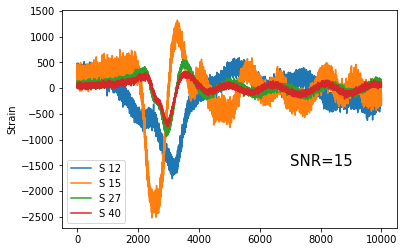

In [137]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    if c==0:
      l0=12
    elif c==1:
      l0=15
    elif c==2:
      l0=27
    else:
      l0 = 40      
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[10], label="S " + str(l0))
plt.legend(loc="best")
plt.text(7000,-1500,'SNR=%s'%SNR,fontsize=15)
plt.ylabel('Strain')
plt.show()
plt.close()

In [76]:
# For stationary check, Groupby labels
ll = pd.DataFrame(label0)
ll.columns = ['Label']
gk = pd.concat([X,ll],axis=1)
gk = gk.groupby('Label')
  
# Let's print the first entries
# in all the groups formed.
#gk.first()

g12 = gk.get_group('12'); g12 = g12.iloc[:,:-1];
g15 = gk.get_group('15'); g15 = g15.iloc[:,:-1];
g27 = gk.get_group('27'); g27 = g27.iloc[:,:-1];
g40 = gk.get_group('40'); g40 = g40.iloc[:,:-1];
print(np.shape(g12))
print(np.shape(g15))
print(np.shape(g27))
print(np.shape(g40))

(96, 10000)
(99, 10000)
(102, 10000)
(104, 10000)


When the test statistic is **lower** than the critical value shown, you **reject the null hypothesis** and infer that the **time series is stationary**.


p < 0.05 = Stationary


p > 0.05 = Non- Stationary

0.0625
0.0
0.04040404040404041
0.058823529411764705


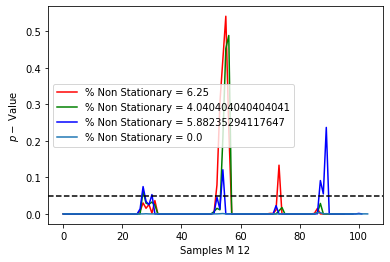

In [115]:
from statsmodels.tsa.stattools import adfuller
# ADF Test
# Function to print out results in customised manner
#import random
#n = random.randint(0,500)
#print(n)
p12 = []; p_high=[];c=0.;T=96;
for i in range(T):
  p12.append(adfuller(g12.iloc[i])[1])
  if (adfuller(g12.iloc[i])[1] > 0.05):
    p_high.append(adfuller(g12.iloc[i])[1]) 
    c+=1
print(c/T) 
fr12 = c/T   
fr12 = fr12 *100.

p40 = []; p_high=[];c=0.;T=104;
for i in range(T):
  p40.append(adfuller(g40.iloc[i])[1])
  if (adfuller(g40.iloc[i])[1] > 0.05):
    p_high.append(adfuller(g40.iloc[i])[1]) 
    c+=1
print(c/T) 
fr40 = c/T   
fr40 = fr40 *100.

p15 = []; p_high=[];c=0.;T=99;
for i in range(T):
  p15.append(adfuller(g15.iloc[i])[1])
  if (adfuller(g15.iloc[i])[1] > 0.05):
    p_high.append(adfuller(g15.iloc[i])[1]) 
    c+=1
print(c/T) 
fr15 = c/T   
fr15 = fr15 *100.
p27 = []; p_high=[];c=0.;T=102;
for i in range(T):
  p27.append(adfuller(g27.iloc[i])[1])
  if (adfuller(g27.iloc[i])[1] > 0.05):
    p_high.append(adfuller(g27.iloc[i])[1]) 
    c+=1
print(c/T) 
fr27 = c/T   
fr27 = fr27 *100.


plt.plot(p12,c='r',label='M 12, %% Non Stationary = %.2f'%fr12)
plt.plot(p15,c='g',label='M 15, %%%.2f'%fr15)
plt.plot(p27,c='b',label='M 27, %%%.2f'%fr27)
plt.plot(p40,label='M 40, %%%.2f'%fr40)

plt.axhline(0.05,linestyle='--',c='black')
plt.xlabel('Samples')
plt.ylabel('$p-$ Value')
plt.legend(loc='best')

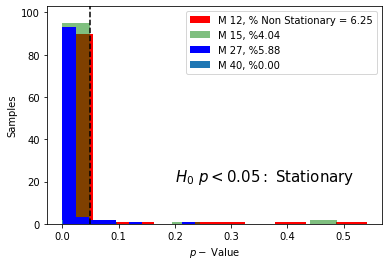

In [134]:
plt.hist(p12,color='r',label='M 12, %% Non Stationary = %.2f'%fr12)
plt.hist(p15,color='g',alpha=0.5,label='M 15, %%%.2f'%fr15)
plt.hist(p27,color='b',label='M 27, %%%.2f'%fr27)
plt.hist(p40,label='M 40, %%%.2f'%fr40)

plt.axvline(0.05,linestyle='--',c='black')
plt.text(0.2,20,'$H_0\ p<0.05:$ Stationary',fontsize=15,c='black')
#plt.ylim(-0.1,0.1)
plt.ylabel('Samples')
plt.xlabel('$p-$ Value')
plt.legend(loc='best')

In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [7]:
num_classes = len(np.unique(y_train))

In [8]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

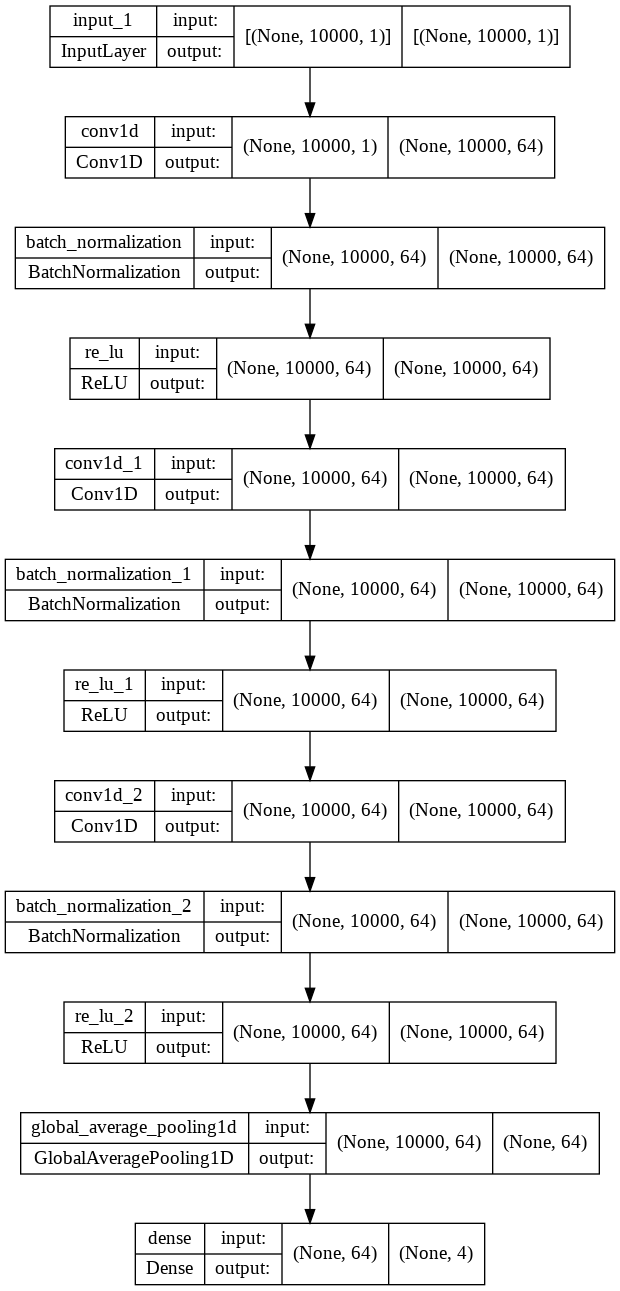

In [9]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    #cpnv2 = keras.layers.Dropout(0.5)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [10]:
epochs = 500
batch_size = 50

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=50, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
6/6 [==============================] - 21s 3s/step - loss: 1.4075 - sparse_categorical_accuracy: 0.2361 - val_loss: 1.8818 - val_sparse_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 2/500
6/6 [==============================] - 19s 3s/step - loss: 1.3827 - sparse_categorical_accuracy: 0.2708 - val_loss: 1.6870 - val_sparse_categorical_accuracy: 0.2222 - lr: 0.0010
Epoch 3/500
6/6 [==============================] - 19s 3s/step - loss: 1.3772 - sparse_categorical_accuracy: 0.3090 - val_loss: 1.7321 - val_sparse_categorical_accuracy: 0.1944 - lr: 0.0010
Epoch 4/500
6/6 [==============================] - 20s 3s/step - loss: 1.3623 - sparse_categorical_accuracy: 0.3194 - val_loss: 1.6568 - val_sparse_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 5/500
6/6 [==============================] - 21s 4s/step - loss: 1.3517 - sparse_categorical_accuracy: 0.3021 - val_loss: 1.6242 - val_sparse_categorical_accuracy: 0.1528 - lr: 0.0010
Epoch 6/500
6/6 [==============================] -

In [18]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 [==============================] - 1s 130ms/step - loss: 1.2299 - sparse_categorical_accuracy: 0.3902
Test accuracy 0.39024388790130615
Test loss 1.2299412488937378


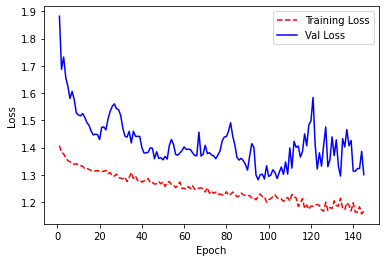

In [143]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

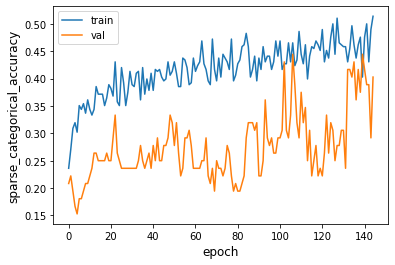

In [144]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
#plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [13]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_pred_train = np.argmax(model.predict(x_train), axis=-1)

In [14]:
import sklearn.metrics as skm
print('----------------')
print('Test Data ')
print('----------------')
print(skm.classification_report( y_test , y_pred ))
print('----------------')
print('Train Data')
print('----------------')
print(skm.classification_report( y_train , y_pred_train ))

----------------
Test Data 
----------------
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.29      0.56      0.38         9
           2       0.33      0.11      0.17         9
           3       0.45      0.82      0.58        11

    accuracy                           0.39        41
   macro avg       0.52      0.39      0.32        41
weighted avg       0.55      0.39      0.32        41

----------------
Train Data
----------------
              precision    recall  f1-score   support

           0       0.44      0.05      0.09        84
           1       0.37      0.54      0.44        90
           2       0.32      0.18      0.23        93
           3       0.45      0.80      0.57        93

    accuracy                           0.40       360
   macro avg       0.40      0.39      0.33       360
weighted avg       0.39      0.40      0.34       360



In [145]:
#cm_analysis(y_test, y_pred, np.argmax(model.predict(x_test), axis=-1), ymap=None, figsize=(20,20))

In [16]:
y_test

array([2, 2, 0, 2, 0, 0, 3, 0, 2, 1, 0, 3, 0, 0, 1, 0, 2, 2, 2, 2, 0, 0,
       3, 3, 0, 3, 1, 3, 3, 1, 3, 1, 2, 0, 3, 1, 1, 3, 1, 1, 3])

In [17]:
y_pred

array([2, 3, 2, 3, 1, 1, 1, 1, 3, 3, 1, 3, 0, 1, 1, 1, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 2, 3, 1, 3, 3, 1, 3, 3])